In [3]:
import cv2
import os

# import argparse
# parser = argparse.ArgumentParser(description='control SRCNN')
# parser.add_argument('--to', action="store",dest="tryout", default=20)
# parser.add_argument('--ep', action="store",dest="epochs", default=50)
# parser.add_argument('--bs', action="store",dest="batch_size", default=64)
# parser.add_argument('--lr', action="store",dest="learning_rate", default=0.0001)
# parser.add_argument('--gpu', action="store",dest="gpu", default=1)

# values = parser.parse_args()
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import sys
import numpy as np
import matplotlib.pyplot as plt
from CREATE_DATA_SET import PARSE_DATA
from keras.models import Model
from keras.layers import Input, Convolution2D
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras import backend as k
import tensorflow as tf

folder = '../sibling-face-data/DBs'
HEIGHT = 120
WIDTH = 160
CHANNEL = 3
pd = PARSE_DATA(folder  , WIDTH= WIDTH , HEIGHT=HEIGHT)

data = pd.get_train_data()
lr_data_2x = pd.get_2x_lower()

print(data.shape)
print(lr_data_2x.shape)

def PSNRLoss(y_true, y_pred):
    return 10* k.log(k.mean(k.square(y_pred - y_true)))

Using TensorFlow backend.


(1080, 120, 160, 3)
(1080, 60, 80, 3)


In [5]:
class SRCNN:
  def __init__(self,width , height , channel , lr):
    self.height = height
    self.width = width
    inputs = Input(shape=(height, width , channel))
    x = Convolution2D(64, (7, 7), activation='relu', init='he_normal' , border_mode='same')(inputs)
    x = Convolution2D(128, (5,5), activation='relu', init='he_normal' , border_mode='same')(x)
    x = Convolution2D(32, (1, 1), activation='relu', init='he_normal' , border_mode='same')(x)
    x = Convolution2D(16, (3, 3), activation='relu', init='he_normal' , border_mode='same')(x)
    x = Convolution2D(3, (5, 5), init='he_normal' , border_mode='same')(x)
    self.model = Model(input = inputs, output = x)
    adam = Adam(lr=lr, beta_1=0.7, beta_2=0.999, epsilon=1e-8) 
    self.model.compile(loss='mse', optimizer=adam , metrics=[PSNRLoss])
    self.model.summary()
    input()
    
  def fit(self , X , Y ,batch_size=64 , epoch = 100 , gpu=0 ):
    X = np.array([cv2.resize(image, dsize=(self.width , self.height), interpolation=cv2.INTER_CUBIC) for image in X])
    # with tf.device('/gpu:'+str(gpu)):
    for i in range(epoch):    
        print("epoch: ",i)
        out = self.model.fit(X, Y , batch_size = batch_size , verbose =1 , nb_epoch=1)
  
  def get_model(self):
    return self.model

  def generate(self , X ):
    X = cv2.resize(X, dsize=(self.width , self.height), interpolation=cv2.INTER_CUBIC)
    return self.model.predict(np.array([X]))

In [6]:
learning_rate = 0.0001
batch_size = 32
epochs = 50
tryout = 1000
gpu= 0

In [7]:
from PIL import Image

lr_data_8x = pd.get_8x_lower()
Y_data = pd.get_train_data()

model = SRCNN(WIDTH , HEIGHT , CHANNEL , learning_rate)

Image.fromarray(Y_data[0]).save("test_image.jpeg")
Image.fromarray(lr_data_2x[0]).save("test_image_2x.jpeg")
def train():
    for i in range (tryout):
        print("tryout no: ",i)
        model.fit( lr_data_8x, Y_data , epoch = epochs , batch_size=batch_size , gpu = gpu)
        im = model.generate(lr_data_2x[0])[0]
        im[im > 255] = 255
        im[im < 0] = 0
        Image.fromarray(im.astype('uint8')).save("test_image_2x_"+str(i)+"_.jpeg")

/home/sanchit/anaconda/envs/rajat-py3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (7, 7), activation="relu", padding="same", kernel_initializer="he_normal")`
  
/home/sanchit/anaconda/envs/rajat-py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (5, 5), activation="relu", padding="same", kernel_initializer="he_normal")`
  import sys
/home/sanchit/anaconda/envs/rajat-py3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1), activation="relu", padding="same", kernel_initializer="he_normal")`
  
/home/sanchit/anaconda/envs/rajat-py3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation="relu", padding="same", kernel_initializer="he_normal")`
  if __name__ == '__main__':

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 120, 160, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 160, 64)      9472      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 120, 160, 128)     204928    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 120, 160, 32)      4128      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 120, 160, 16)      4624      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 120, 160, 3)       1203      
Total params: 224,355
Trainable params: 224,355
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train()

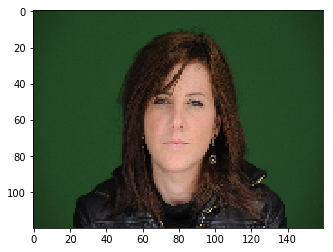

In [9]:
plt.imshow(Y_data[0])

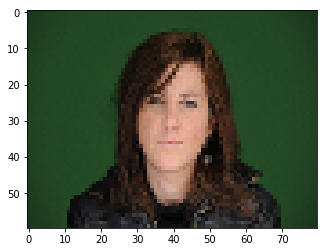

In [10]:
plt.imshow(lr_data_2x[0])

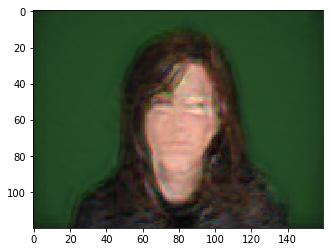

In [11]:
im = model.generate(lr_data_2x[0])[0]
im[im > 255] = 255
im[im < 0] = 0
im = np.array(im , np.uint8)
plt.imshow(im)

# The approch of MSE is the worst of case
### reason being it takes the average of all the possible images in its own domain of distribution
### The MSE could have worked if the data was very specific as mentioned in the original data
### But my data was not simply downscaled image , it had blur and gaussian blur put along with it
### Though i believed this would also work , i was hugely wrong and just like any mean method that goes with the outliers
### The MSE use in deep learning purpose in either of the large scale or small scale networks gives a similar result. Swaying away with the outliers. 
### The MSE with gram loss though is a different case since we no longer dealing with just pixel data, we are dealing with representation of  those datas created by other models
### So furthur model experimentation with data should consider this. 
### SRCNN taked immense training only because its architecture is smaller
### But making it larger should change things
### Will try one last time with non noisy data put in